# Importing Libraries & Dataset

In [5]:
# Loading required libraries

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wordcloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

from bs4 import BeautifulSoup

In [6]:
# Loading dataset, due to github limited upload size limit, can not host csv file on github.
# But dataset was taken from Kaggle at - https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

dataset = pd.read_csv('IMDB Dataset.csv')

# Data Preperation & Vizulization

In [7]:
# Looking at head and tail of our dataset, we can see there are 50,000 records
# We also see  <br/> tags in one of comment, that means it include html tags. We need to remove that in cleaning process

dataset.head(), dataset.tail()

(                                              review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive,
                                                   review sentiment
 49995  I thought this movie did a down right good job...  positive
 49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
 49997  I am a Catholic taught in parochial elementary...  negative
 49998  I'm going to have to disagree with the previou...  negative
 49999  No one expects the Star Trek movies to be high...  negative)

In [8]:
# Looking at dataset info

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
dataset.shape

(50000, 2)

In [9]:
# We can see there are 49582 unique comments where one comment appears for 5 times (usually means comment was copy pasted)
dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [10]:
# Check for any empty values in data
dataset.empty

False

In [11]:
# Looking at comment frequency for each sentiment
dataset.groupby("sentiment").describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  How has this piece of crap stayed on TV this l...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

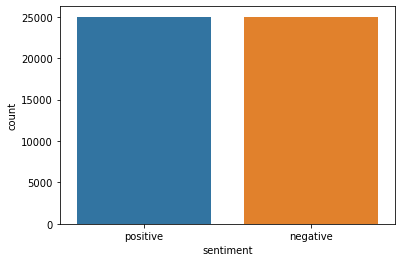

In [12]:
# Plotting reviews based on sentiment
ax = sns.countplot(x="sentiment", data=dataset)

In [13]:
# Creating new column and encode review length size for for corresponding row

dataset['sentence_length'] = dataset['review'].apply(len)

In [14]:
dataset.head()

,review,sentiment,sentence_length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


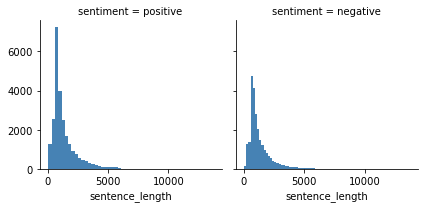

In [15]:
# Plotting review length for each sentiment

ax = sns.FacetGrid(dataset, col="sentiment")
ax.map(plt.hist, "sentence_length", color="steelblue", bins=50)

In [16]:
# Sort dataframe in ascending order

# We can see generally positive reviews has higher sentence length ,this might be due to people who enjoy movies
# tend to write in details what they enjoyed about movies.

# On other hand least amount of sentence_length reviews are of negative type.

dataset.sort_values('sentence_length', ascending=False)

,review,sentiment,sentence_length
31481,Match 1: Tag Team Table Match Bubba Ray and Sp...,positive,13704
40521,There's a sign on The Lost Highway that says:<...,positive,12988
31240,"(Some spoilers included:)<br /><br />Although,...",positive,12930
31436,"Back in the mid/late 80s, an OAV anime by titl...",positive,12129
5708,**Attention Spoilers**<br /><br />First of all...,positive,10363
...,...,...,...
19874,This movie is terrible but it has some good ef...,negative,52
28920,Primary plot!Primary direction!Poor interpreta...,negative,51
40817,I hope this group of film-makers never re-unites.,negative,49
31072,"What a script, what a story, what a mess!",negative,41


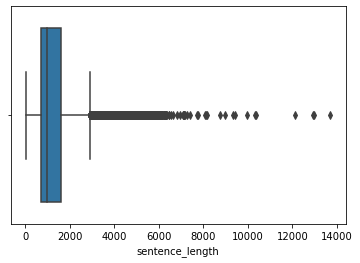

In [17]:
ax = sns.boxplot(x=dataset["sentence_length"])

In [18]:
dataset['sentence_length'].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: sentence_length, dtype: float64

In [19]:
dataset.quantile(0.9)

sentence_length    2581.0
Name: 0.9, dtype: float64

# Cleaning Text and Tag words

In [20]:
# Cleaning our review text to feed into our model

# First we need to download stopwords and wordnet (since we are lemmatizing words)
# More details description between stemming and lemmatizing can be found here https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html#:~:text=Lemmatization%20usually%20refers%20to%20doing,is%20known%20as%20the%20lemma%20.

#nltk.download('stopwords')
#nltk.download('wordnet')
wlm = WordNetLemmatizer()
all_stopwords = stopwords.words('english')

# Creating function to clean reviews
def review_to_words(text):
    # As we saw earlier, reviewes included html tags, we can take them out using beautifulsoup library
    review = BeautifulSoup(text).get_text()
    # We do not need any symbol or number, just letter for review. Using regex we can only keep english letters in review
    review = re.sub('[^a-zA-Z]', ' ', review)
    # convert all words to lower and splitting them in list
    review = review.lower()
    review = review.split()
    # Now we have a list of words, we go through each of them and lemmatize words and also not include stop words
    review = [wlm.lemmatize(word) for word in review if not word in set(all_stopwords)]
    return review

# Apply function and create words column to store clean words
dataset['words'] = dataset['review'].apply(review_to_words)

In [21]:
dataset.head()

,review,sentiment,sentence_length,words
0,One of the other reviewers has mentioned that ...,positive,1761,"[one, reviewer, mentioned, watching, oz, episo..."
1,A wonderful little production. <br /><br />The...,positive,998,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,926,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,748,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,"[petter, mattei, love, time, money, visually, ..."


In [23]:
# We need to combine lists of words in stentence
dataset['review'] = dataset['words'].apply(lambda x: ' '.join(map(str, x)))
dataset.head()

,review,sentiment,sentence_length,words
0,one reviewer mentioned watching oz episode hoo...,positive,1761,"[one, reviewer, mentioned, watching, oz, episo..."
1,wonderful little production filming technique ...,positive,998,"[wonderful, little, production, filming, techn..."
2,thought wonderful way spend time hot summer we...,positive,926,"[thought, wonderful, way, spend, time, hot, su..."
3,basically family little boy jake think zombie ...,negative,748,"[basically, family, little, boy, jake, think, ..."
4,petter mattei love time money visually stunnin...,positive,1317,"[petter, mattei, love, time, money, visually, ..."


In [27]:
# Saving cleaned dataframe in csv if required in future
to_save = dataset.copy()
to_save = to_save.drop(['sentence_length', 'words'], axis=1)
to_save.to_csv('IMDB_review_cleaned.csv', index=False)

In [28]:
# To create a word cloud for each sentiment, lets seperate them into their own dataframe
pos_review = dataset[dataset['sentiment'] == 'positive']
neg_review = dataset[dataset['sentiment'] == 'negative']

In [29]:
text = ' '.join(pos_review['review'].astype(str).tolist())

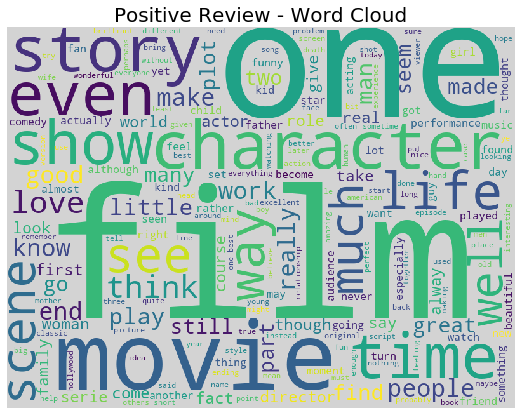

In [30]:
# Display wordcloud for positive review

fig_wordcloud = wordcloud.WordCloud(background_color='lightgrey',
                                    colormap='viridis', width=800, height=600).generate(text)
plt.figure(figsize=(10,7), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.title('Positive Review - Word Cloud', fontsize=20 )
plt.show()

# Most positive review contains film, one, movie, characters ...

In [31]:
text = ' '.join(neg_review['review'].astype(str).tolist())

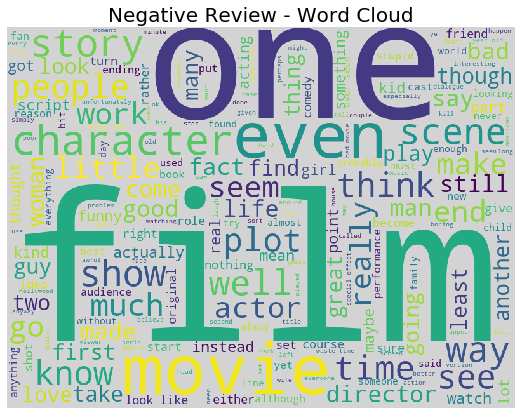

In [32]:
# Display wordcloud for negative review

fig_wordcloud = wordcloud.WordCloud(background_color='lightgrey',
                                    colormap='viridis', width=800, height=600).generate(text)
plt.figure(figsize=(10,7), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.title('Negative Review - Word Cloud', fontsize=20 )
plt.show()

# Most negative review contains word such as film, movie, one, even

# Bag of word model

In [33]:
# Lets use bag of word model first
# More can be learned about bag of word at https://en.wikipedia.org/wiki/Bag-of-words_model#:~:text=The%20bag%2Dof%2Dwords%20model,word%20order%20but%20keeping%20multiplicity.
cv = CountVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
cv_matrix = cv.fit_transform(dataset.review)

## Train Test split

In [34]:
# Splitting in training and test test
X_train, X_test, y_train, y_test = train_test_split(cv_matrix, dataset.sentiment, test_size=0.3, random_state=0)

## Linear SVC

In [35]:
# Using linear SVC to test accuracy
svc_m = LinearSVC()

In [36]:
svc_m.fit(X_train, y_train)

C:\Users\psidd\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [37]:
y_pred = svc_m.predict(X_test)

In [39]:
# Comparing actual sentiment and predicted sentiment
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [41]:
# Creating confusion matrix to look at True positive, True negative, False positive and False negative

# We can see we have 6694 reviews properly identified as positive and 6690 reviews properly identified as negative
# But we have 846 reviews marked as positive while its actually negative, and 770 marked as negative while it was positive
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Accuraccy of Linear SVC is 89.2%
print("Accuracy of Linear SVC on Bag of Word: {}".format(accuracy_score(y_test, y_pred)))

[[6694  846]
 [ 770 6690]]
Accuracy of Linear SVC on Bag of Word: 0.8922666666666667


## Naive Bayes model 

In [42]:
# Using Multinomial Naive Bayes model
NB = MultinomialNB()
NB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
y_pred = NB.predict(X_test)

In [44]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,negative


In [45]:
# Creating confusion matrix to look at True positive, True negative, False positive and False negative

# We can see we have 6666 reviews properly identified as positive and 6605 reviews properly identified as negative
# But we have 874 reviews marked as positive while its actually negative, and 855 marked as negative while it was positive

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Accuracy of Multinomial NB is 88.4%, slightly lower than Linear SVC model
print("Accuracy of Multinomial NB on Bag of Word: {}".format(accuracy_score(y_test, y_pred)))

[[6666  874]
 [ 855 6605]]
Accuracy of Multinomial NB on Bag of Word: 0.8847333333333334


## SGDC Classifier

In [46]:
# Using SGDC classifier model
SGDC = SGDClassifier()
SGDC.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
y_pred = SGDC.predict(X_test)

In [48]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [51]:
# Creating confusion matrix to look at True positive, True negative, False positive and False negative

# We can see we have 6807 reviews properly identified as positive and 6520 reviews properly identified as negative
# But we have 733 reviews marked as positive while its actually negative, and 940 marked as negative while it was positive

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Accuracy of SGDC Classifier is 88.8%.
print("Accuracy of SGDC Classifier on Bag of Word: {}".format(accuracy_score(y_test, y_pred)))

[[6807  733]
 [ 940 6520]]
Accuracy of SGDC Classifier on Bag of Word: 0.8884666666666666


# Term Frequency-Inverse Document Frequency model

In [52]:
# Using Term Frequence - Inverse Document frequency model instead of bag of word.
# More can be learned at https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
tfid = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
tfid_matrix = tfid.fit_transform(dataset.review)

## Train Test split

In [53]:
# Splitting trainging and testing
X_train, X_test, y_train, y_test = train_test_split(tfid_matrix, dataset.sentiment, test_size=0.3, random_state=0)

## Linear SVC

In [54]:
# Testing Linear SVC model
svc_m = LinearSVC()

In [55]:
svc_m.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [56]:
y_pred = svc_m.predict(X_test)

In [57]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [59]:
# Creating confusion matrix to look at True positive, True negative, False positive and False negative

# We can see we have 6772 reviews properly identified as positive and 6818 reviews properly identified as negative
# But we have 768 reviews marked as positive while its actually negative, and 642 marked as negative while it was positive
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Accuraccy of Linear SVC is 90.6%
print("Accuracy of Linear SVC on Bag of Word: {}".format(accuracy_score(y_test, y_pred)))

[[6772  768]
 [ 642 6818]]
Accuracy of Linear SVC on Bag of Word: 0.906


## Naive Bayes model 

In [60]:
NB = MultinomialNB()
NB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [61]:
y_pred = NB.predict(X_test)

In [62]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [64]:
# Creating confusion matrix to look at True positive, True negative, False positive and False negative

# We can see we have 6644 reviews properly identified as positive and 6677 reviews properly identified as negative
# But we have 896 reviews marked as positive while its actually negative, and 783 marked as negative while it was positive

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Accuracy of Multinomial NB is 88.8%
print("Accuracy of Multinomial NB on Bag of Word: {}".format(accuracy_score(y_test, y_pred)))

[[6644  896]
 [ 783 6677]]
Accuracy of Multinomial NB on Bag of Word: 0.8880666666666667


## SGDC Classifier

In [65]:
SGDC = SGDClassifier()
SGDC.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [66]:
y_pred = SGDC.predict(X_test)

In [67]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [69]:
# Creating confusion matrix to look at True positive, True negative, False positive and False negative

# We can see we have 6602 reviews properly identified as positive and 6829 reviews properly identified as negative
# But we have 938 reviews marked as positive while its actually negative, and 631 marked as negative while it was positive

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Accuracy of SGDC Classifier is 89.5%.
print("Accuracy of SGDC Classifier on Bag of Word: {}".format(accuracy_score(y_test, y_pred)))

[[6602  938]
 [ 631 6829]]
Accuracy of SGDC Classifier on Bag of Word: 0.8954


# Conclusion

Out of all model above, it looks like TF-IDF method with linear SVC model is giving us more accuracy than other model

In [70]:
# Testing our own review with TF-IDF method and linear CSV model

text = ['Really wonderfull movies, I liked every second of it']
extra = pd.Series(text)
review_series = dataset.review.append(extra, ignore_index=True)

tfid = TfidfVectorizer(ngram_range=(1,2))
tfid_transformed = tfid.fit_transform(review_series)

In [71]:
tfid_matrix = tfid_transformed[:50000]
tfid_predict = tfid_transformed[-1:]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(tfid_matrix, dataset.sentiment, test_size=0.3, random_state=0)

svc_m = LinearSVC()
svc_m.fit(tfid_matrix, dataset.sentiment)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [73]:
y_pred = svc_m.predict(tfid_predict)

In [75]:
# We can see it predicted perfectly to our sentence.
y_pred

array(['positive'], dtype=object)

In [76]:
# Creating a method of our model to test other sentence

def predict_sentence(text, df):
    text = BeautifulSoup(text).get_text()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = [text]
    
    extra = pd.Series(text)
    review_series = df.review.append(extra, ignore_index=True)
    
    tfid = TfidfVectorizer(ngram_range=(1,2))
    tfid_transformed = tfid.fit_transform(review_series)
    
    tfid_matrix = tfid_transformed[:50000]
    tfid_predict = tfid_transformed[-1:]
    
    X_train, X_test, y_train, y_test = train_test_split(tfid_matrix, df.sentiment, test_size=0.3, random_state=0)
    
    svc_m = LinearSVC()
    svc_m.fit(tfid_matrix, df.sentiment)
    
    y_pred = svc_m.predict(tfid_predict)
    
    return y_pred

In [77]:
predict_sentence('Movie was really bad', dataset)

array(['negative'], dtype=object)

In [78]:
predict_sentence('Wonderful movie, I enjoyed every second of it. Would love to watch again.', dataset)

array(['positive'], dtype=object)